In [1]:
import transformers
import torch
import json
from tqdm import tqdm
from transformers import BertTokenizer
import pandas as pd
from utils import QADataset, collate_fn, preprocess
from transformers import BertForQuestionAnswering
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
PRETRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
valid = preprocess("data/dev.json", "test")
validset = QADataset(valid, "test", tokenizer=tokenizer)
validloader = DataLoader(validset, batch_size=16, 
                         collate_fn=collate_fn)

In [33]:
context_len_list = []
for c in train['answers']:
    temp = len(tokenizer.tokenize(c[0]['text']))
    if(temp):
        context_len_list.append(temp)


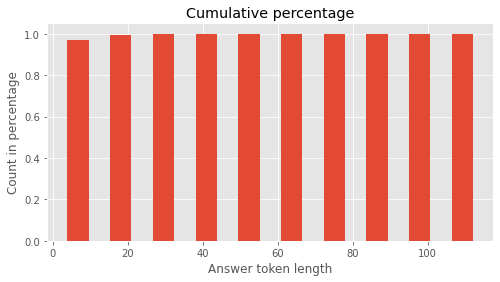

In [35]:
%matplotlib inline
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Cumulative percentage')
ax.set_xlabel('Answer token length')
ax.set_ylabel('Count in percentage')
n, bins, patches = ax.hist(context_len_list,cumulative=True, density=True, rwidth=0.5)
plt.show()
print(n, bins, patches)

In [3]:
PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 2
model = BertForQuestionAnswering.from_pretrained(
    PRETRAINED_MODEL_NAME)

model.load_state_dict(torch.load('./save/QA-final.pkl'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()

In [14]:
def remove_word(sentence):
    stop_words = ['##', '[UNK]', '[CLS]']
    for s in stop_words:
        sentence = sentence.replace(s, '')
    return sentence

def predict(model, dataloader, thresh, device):
    predictions = None
    correct = 0
    total = 0
    total_loss = 0
    predictions = {}
    with torch.no_grad():
        # 遍巡整個資料集
        for data in tqdm(dataloader):
            # 將所有 tensors 移到 GPU 上
            ids = data[5]
            data = [t.to(device) for t in data[:-1]]
            
            # 別忘記前 3 個 tensors 分別為 tokens, segments 以及 masks
            # 且強烈建議在將這些 tensors 丟入 `model` 時指定對應的參數名稱
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            start_scores, end_scores = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            start_scores = torch.nn.functional.softmax(start_scores)
            end_scores = torch.nn.functional.softmax(end_scores)
            for i in range(len(data[0])):
                id = ids[i]
                all_tokens = tokenizer.convert_ids_to_tokens(tokens_tensors[i])
                start, end = torch.argmax(start_scores[i]), torch.argmax(end_scores[i])
                scorer = start_scores[i]+end_scores[i]
                retry = 1
                while(end - start >= 30 or start > end or (not start)):
                    retry += 1
                    if start == 0:
                        _, starts = torch.topk(start_scores[i], retry)
                        start = starts[retry-1]
                    else:
                        _, ends = torch.topk(end_scores[i], retry)
                        end = ends[retry-1]
                is_answerable = torch.sigmoid(torch.tensor([scorer[0], (start_scores[i][start] + end_scores[i][end])]))
#                 print(is_answerable, torch.tensor([scorer[0], start_scores[i][start] + end_scores[i][end]]))
                if(is_answerable[0] > thresh):
                    predictions[id] = ''
                else:
                    temp = ''.join(all_tokens[start:end])
                    predictions[id] = remove_word(temp)

    return predictions

def threshold_compare(model, dataloader, thresh, device):
    cnt = 0
    for t in thresh:
        predictions = predict(model, dataloader, t, device)
        json.dump(predictions, open('./output/'+str(cnt)+'.json', "w"))
        cnt+=1
        
def json_open(data_path):
    with open(data_path, encoding="utf-8") as f:
        data = json.load(f)
    return data

def plot_line(data, thresh, title, label_x, label_y):
    plt.style.use('ggplot')
    plt.plot(thresh, data['overall'], label="overall")
    plt.plot(thresh, data['answerable'], label="answerable")
    plt.plot(thresh, data['unanswerable'], label="unanswerable")
    plt.legend(loc='lower right')
    plt.scatter(thresh, data['overall'])
    plt.scatter(thresh, data['answerable'])
    plt.scatter(thresh, data['unanswerable'])

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.show()

In [15]:
thresh = [0.1,0.3,0.5,0.7,0.9]
threshold_compare(model, validloader, thresh, device)
# prediction = predict(model, validloader, 0.95, device)

  0%|          | 0/315 [00:00<?, ?it/s]/home/shizuku/frank2/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/shizuku/frank2/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 315/315 [02:03<00:00,  2.54it/s]


In [16]:
F1 = {'overall':[], 'answerable':[], 'unanswerable':[]}
EM = {'overall':[], 'answerable':[], 'unanswerable':[]}
for i, t in enumerate(thresh):
    data = json_open('./output/eval_'+str(i)+'.json')
    for key in F1.keys():
        F1[key].append(data[key]['f1'])
        EM[key].append(data[key]['em'])
    

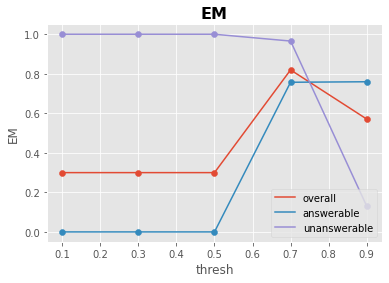

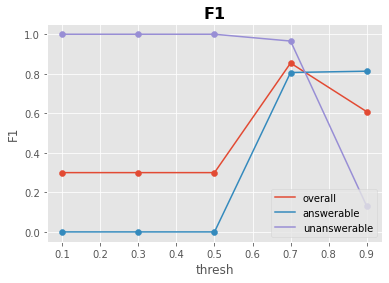

In [17]:
plot_line(EM, thresh, "EM", "thresh", "EM")
plot_line(F1, thresh, "F1", "thresh", "F1")

In [9]:
F1

{'overall': [0.29996027016289234,
  0.29996027016289234,
  0.29996027016289234,
  0.8540372355640677,
  0.6082064257906763],
 'answerable': [0.0, 0.0, 0.0, 0.8062495584079225, 0.8126308590891784],
 'unanswerable': [1.0, 1.0, 1.0, 0.9655629139072848, 0.13112582781456952]}

In [15]:
EM

{'overall': [0.29996027016289234,
  0.29996027016289234,
  0.29996027016289234,
  0.8386968613428685,
  0.5953516090584029],
 'answerable': [0.0, 0.0, 0.0, 0.7942678774120318, 0.7942678774120318],
 'unanswerable': [1.0, 1.0, 1.0, 0.9423841059602649, 0.13112582781456952]}